In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 300
})

from Finite_volume_method_1D import *

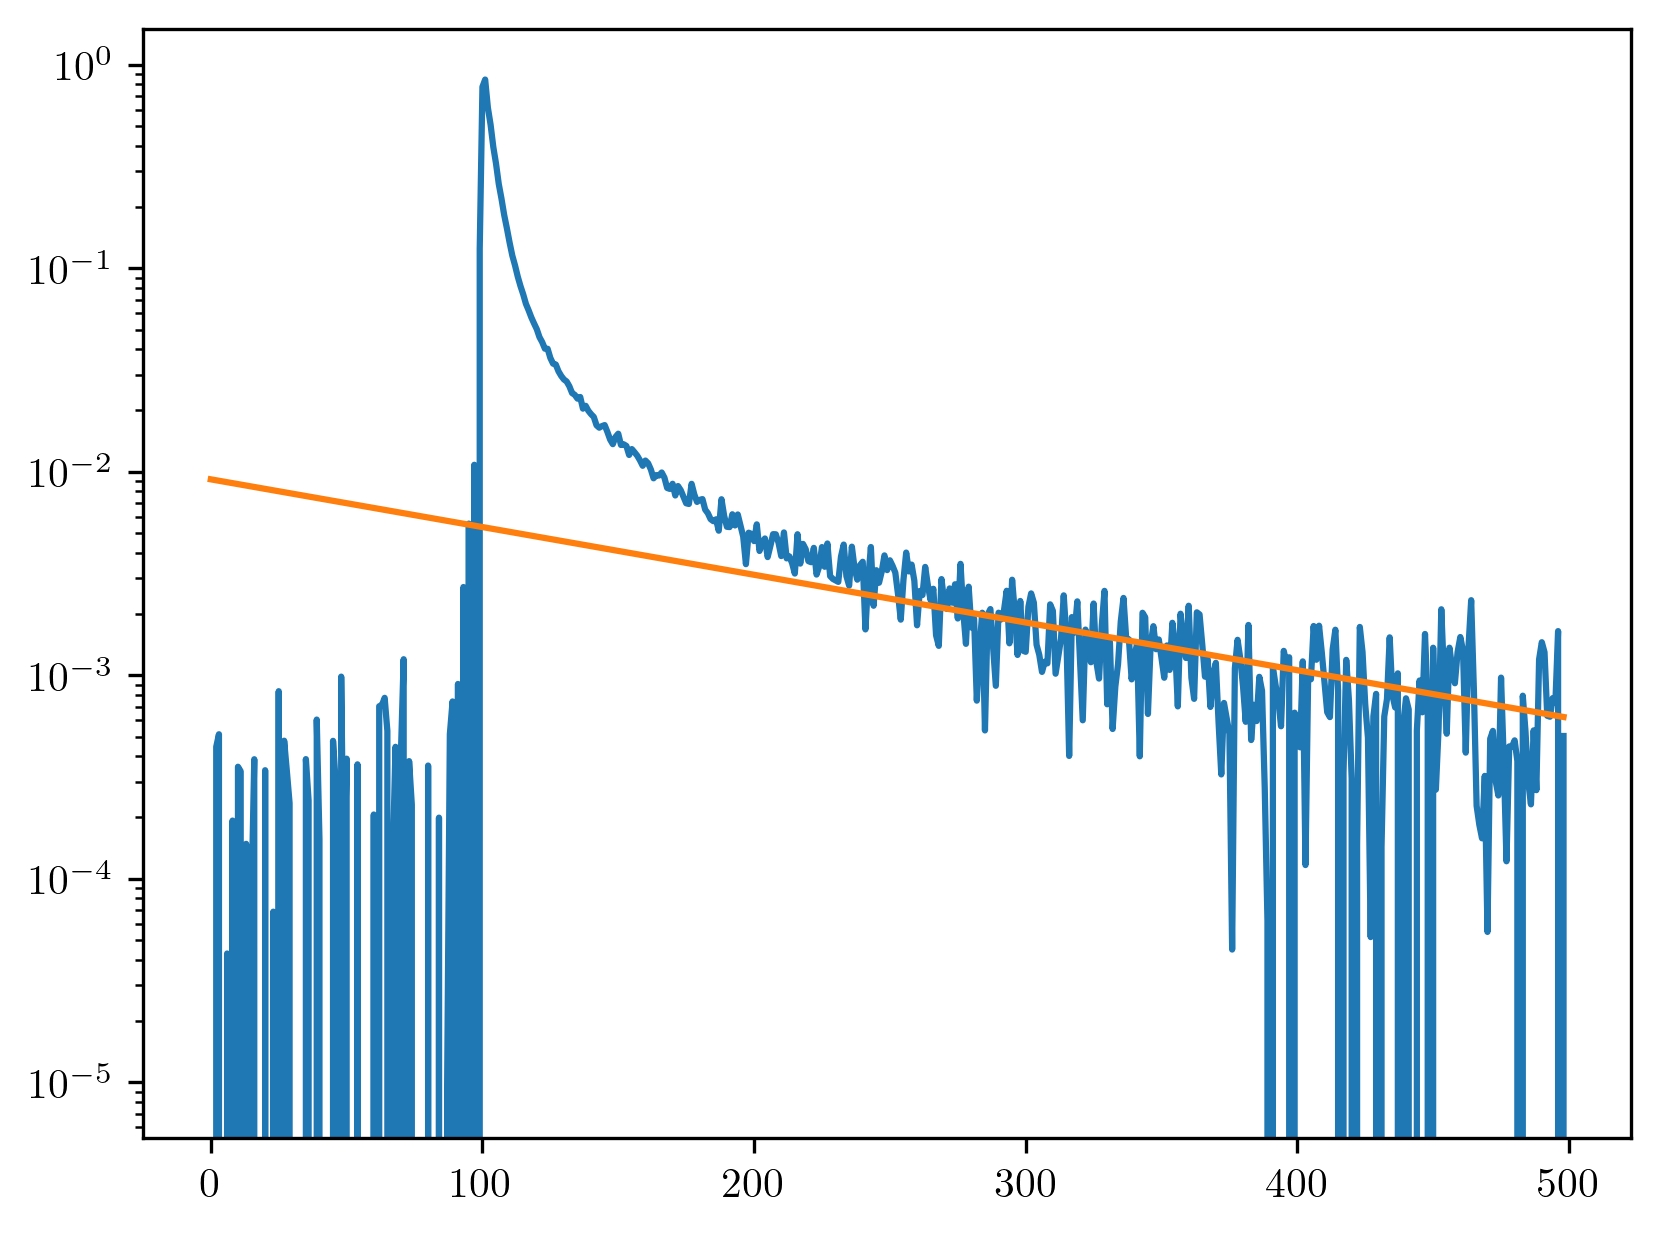

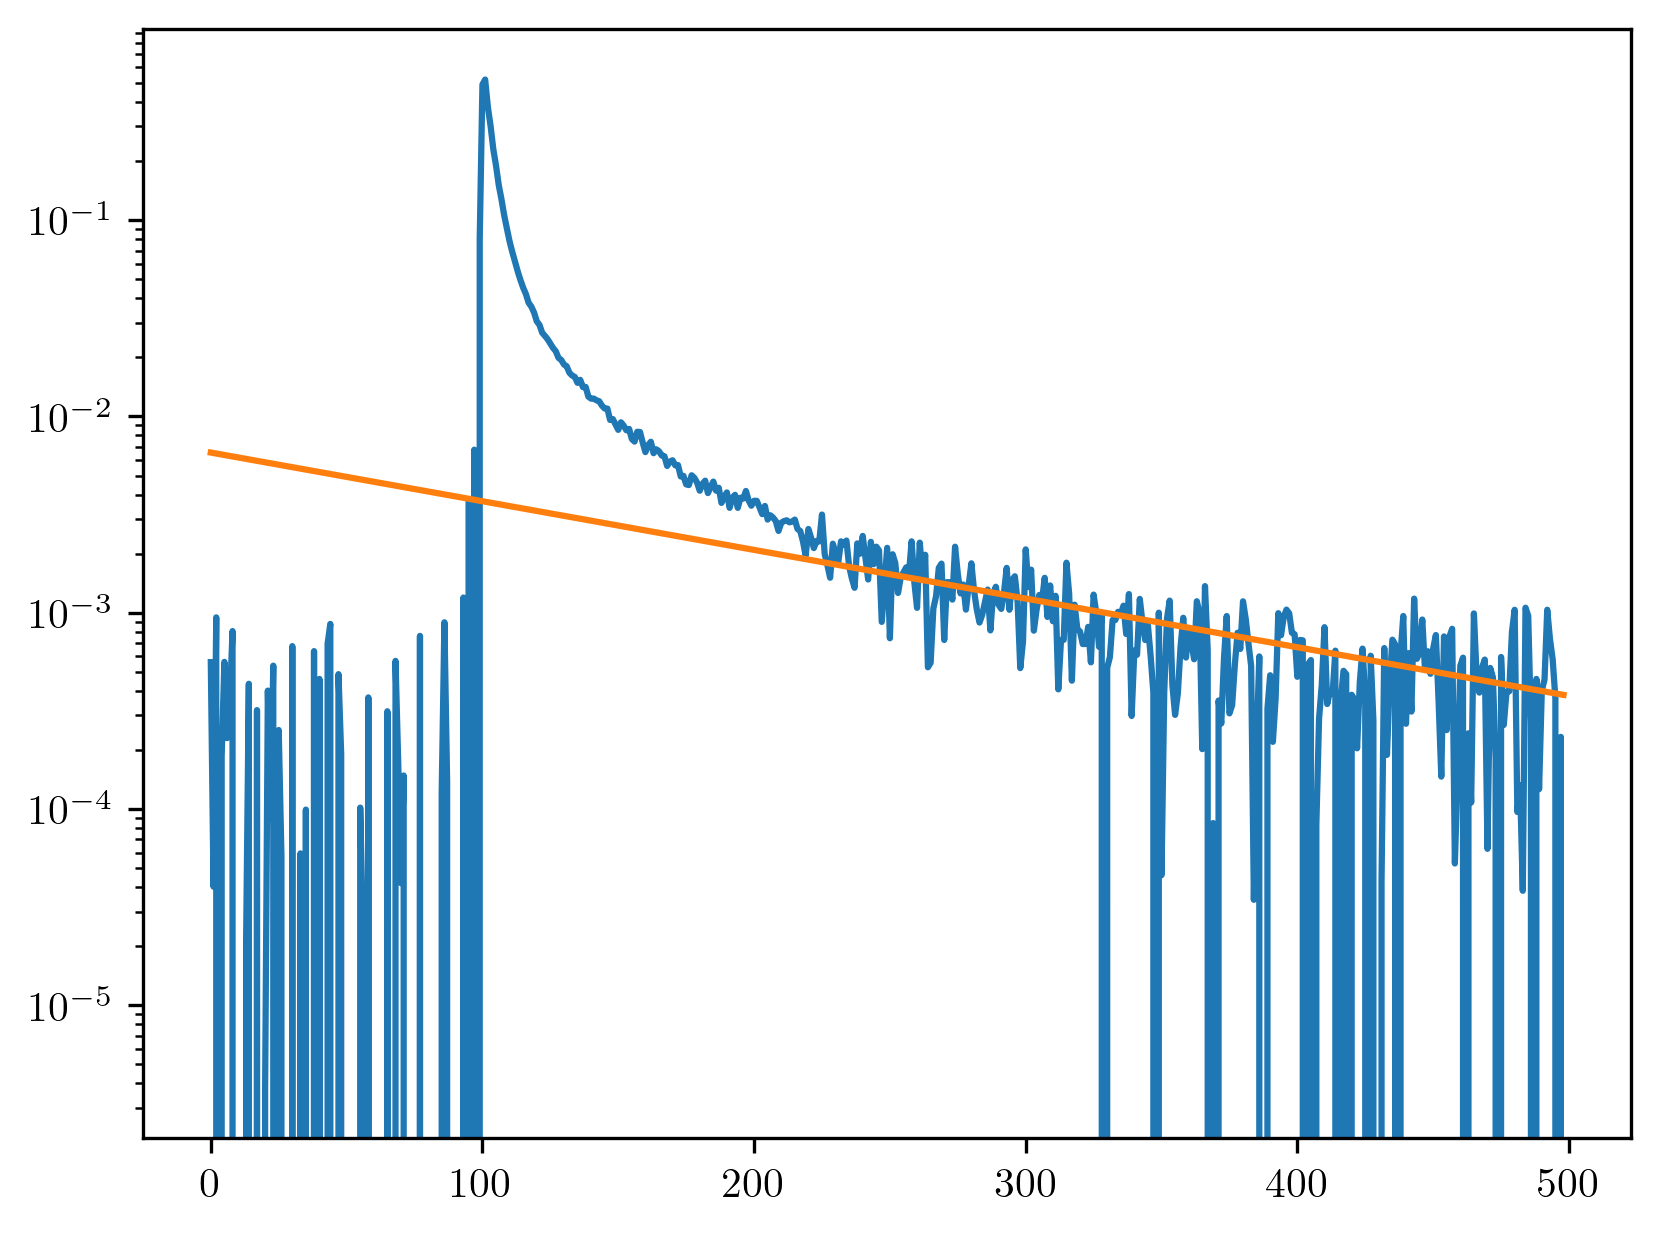

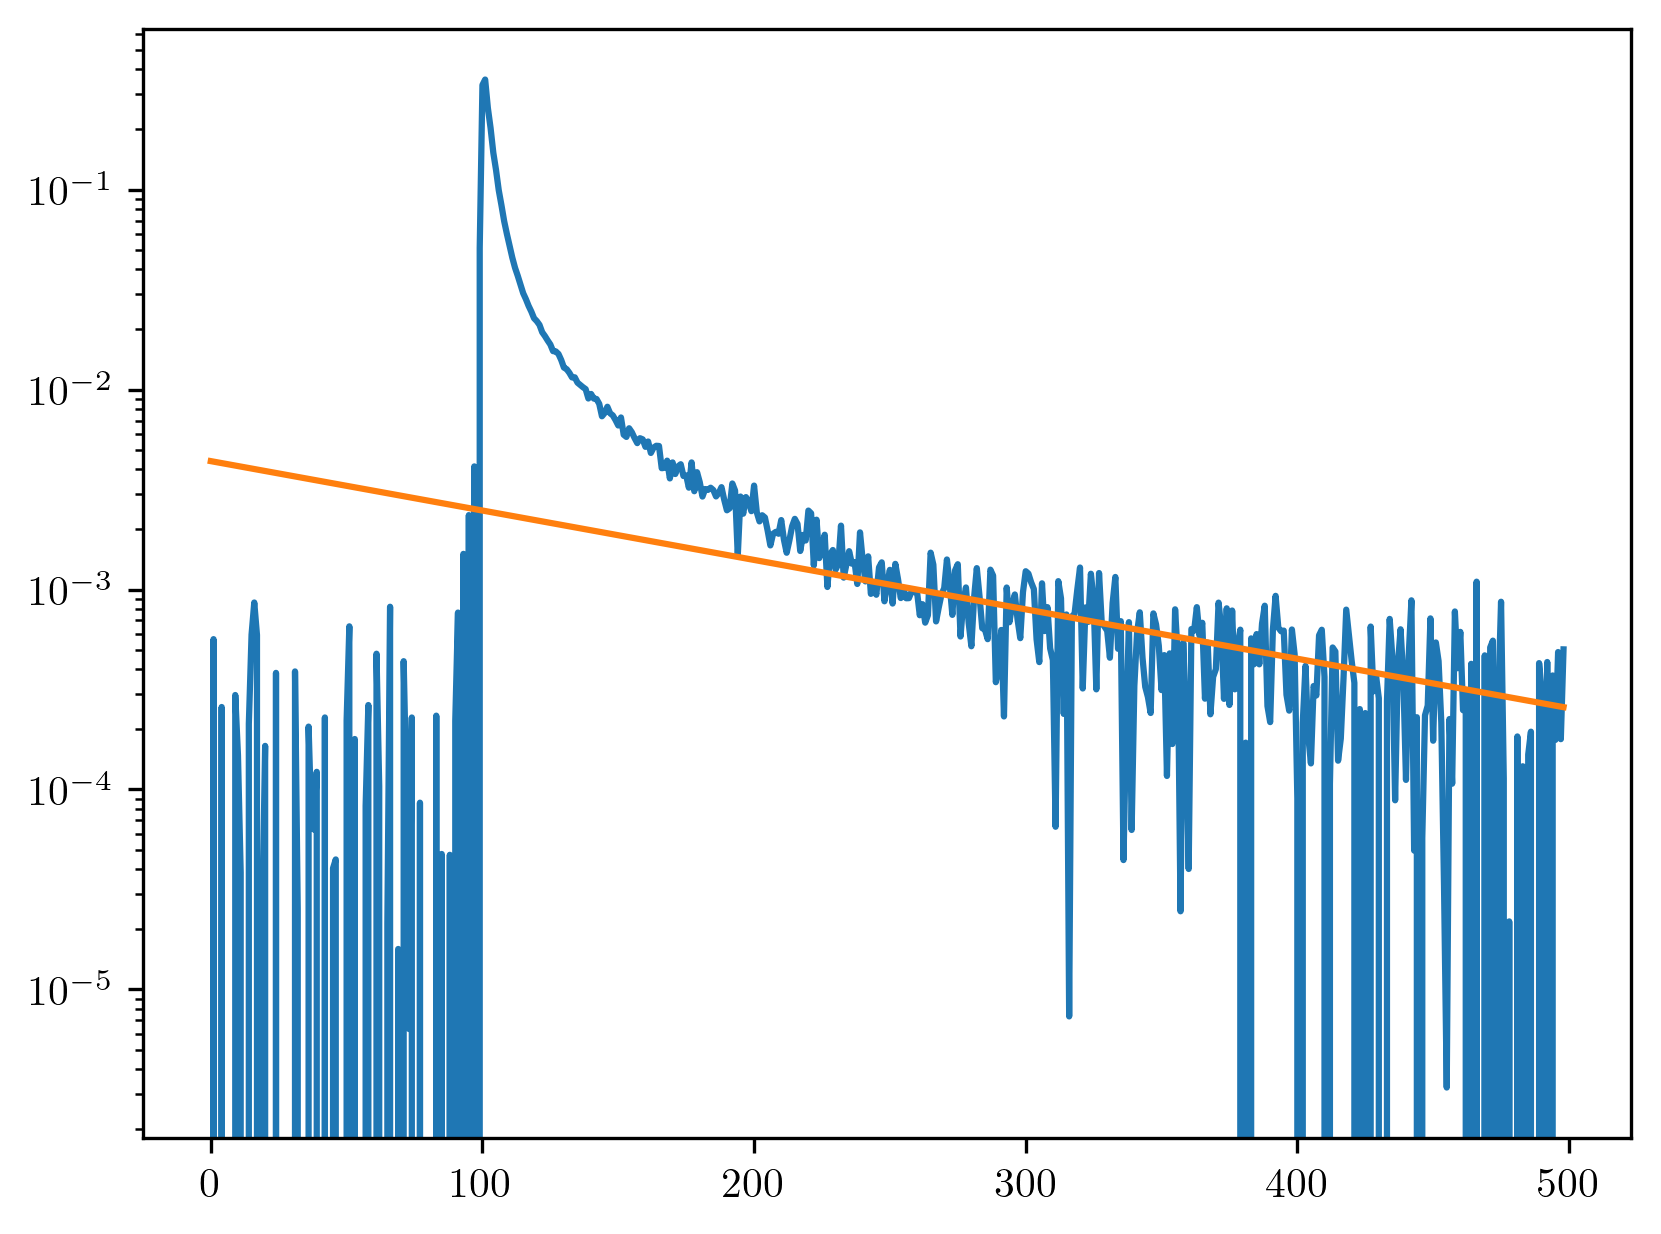

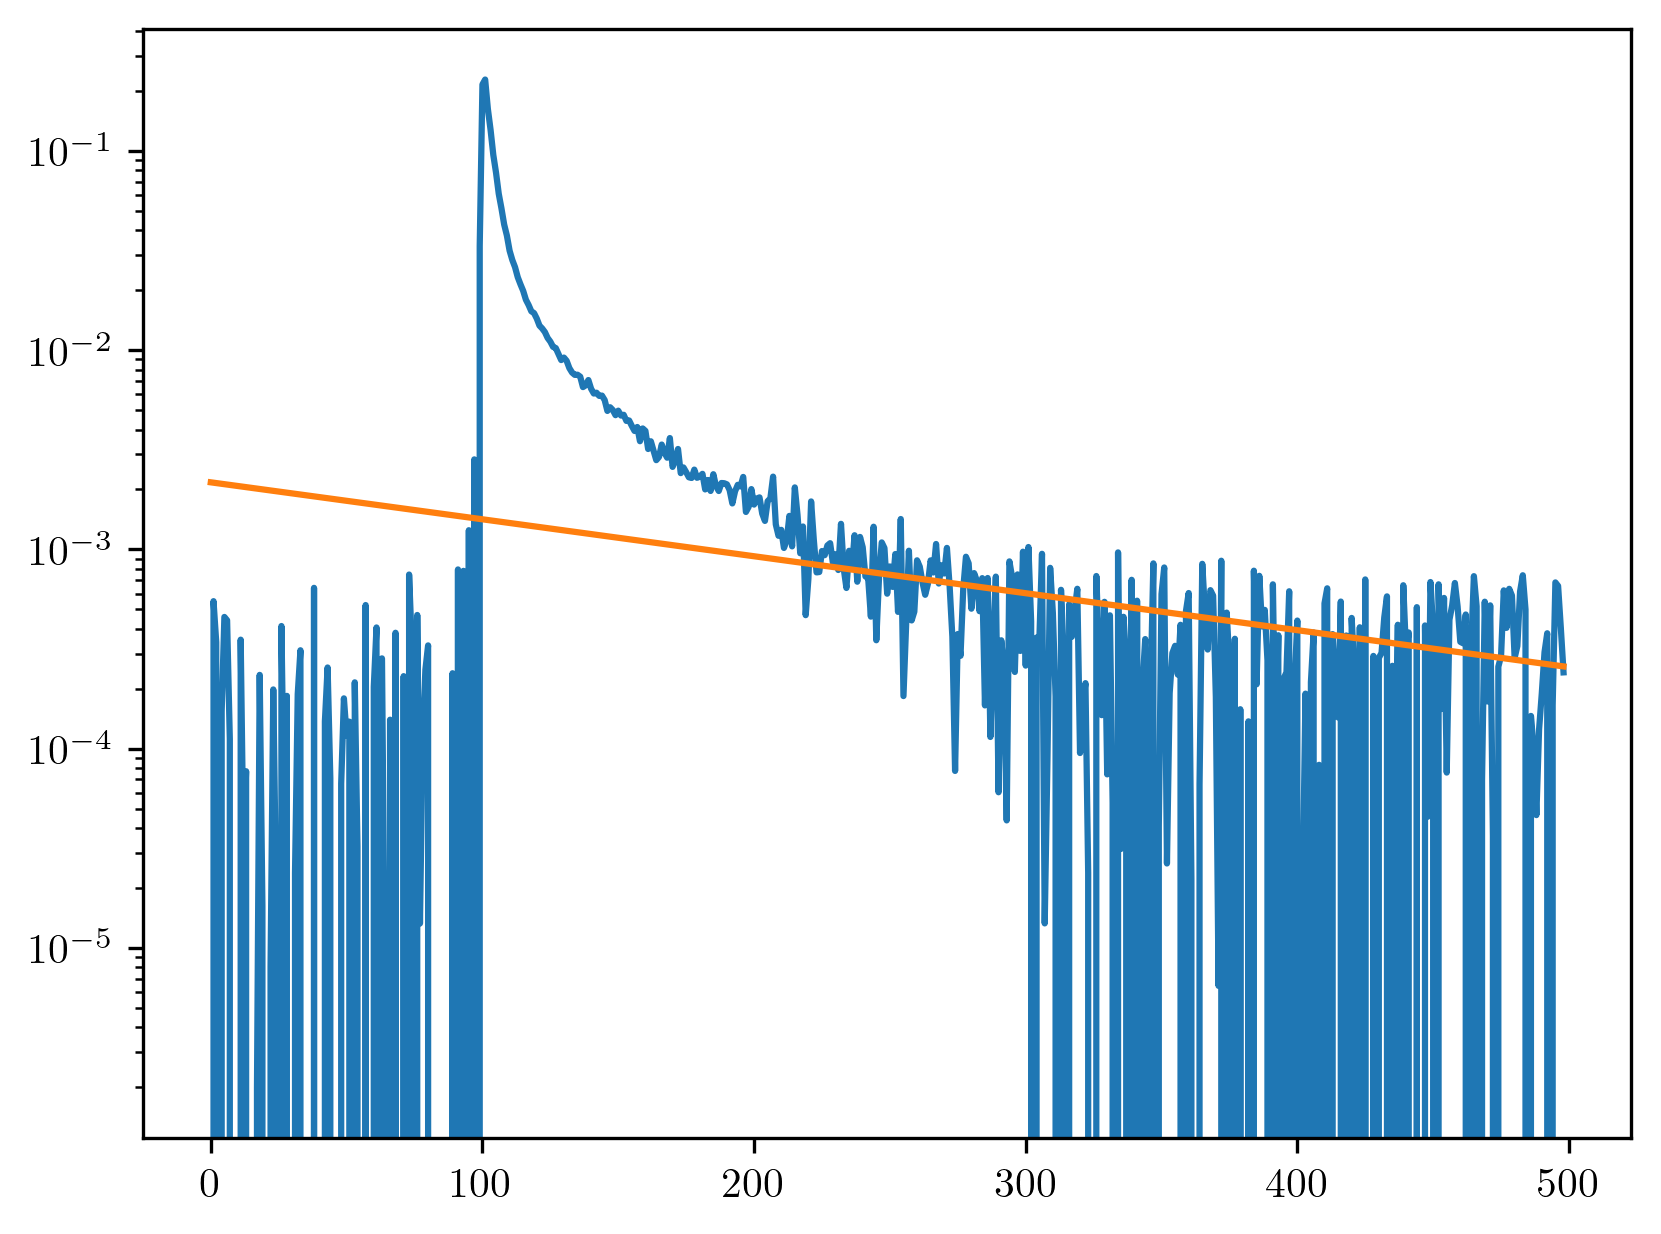

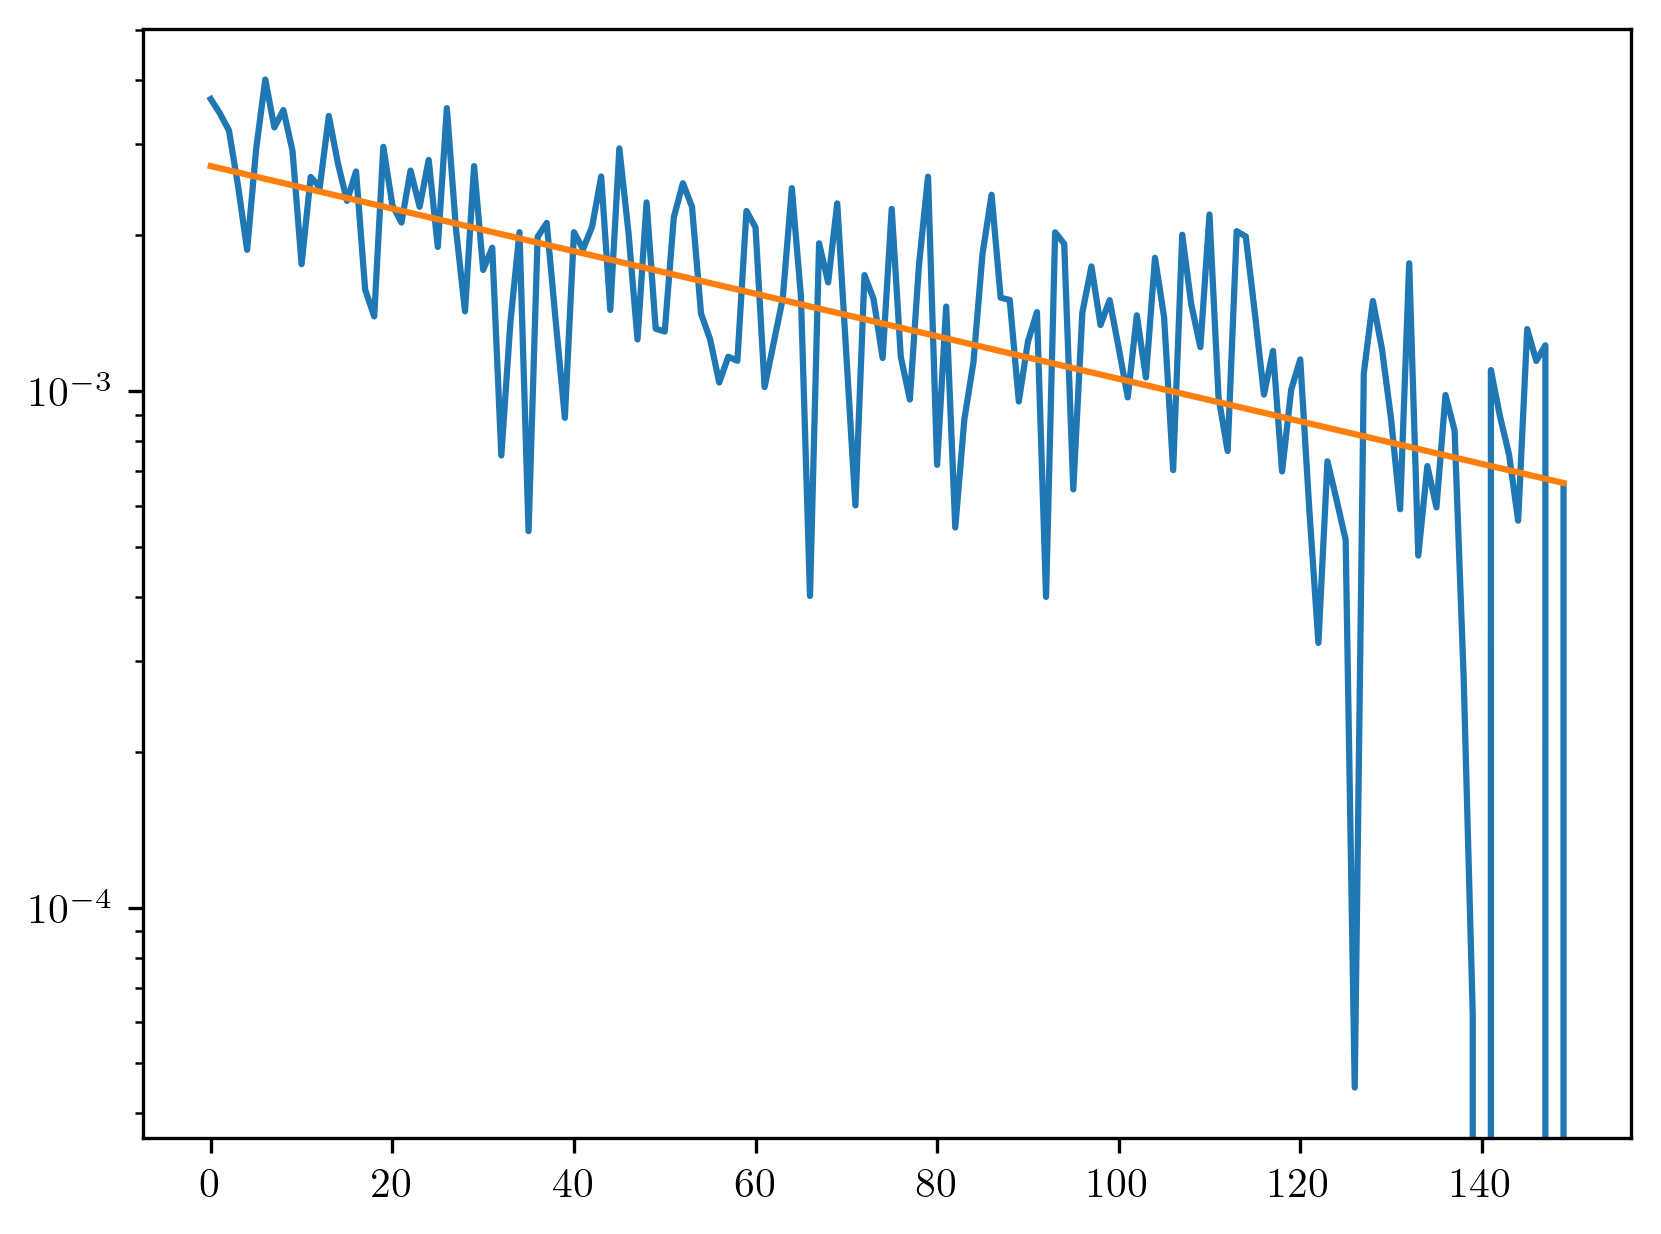

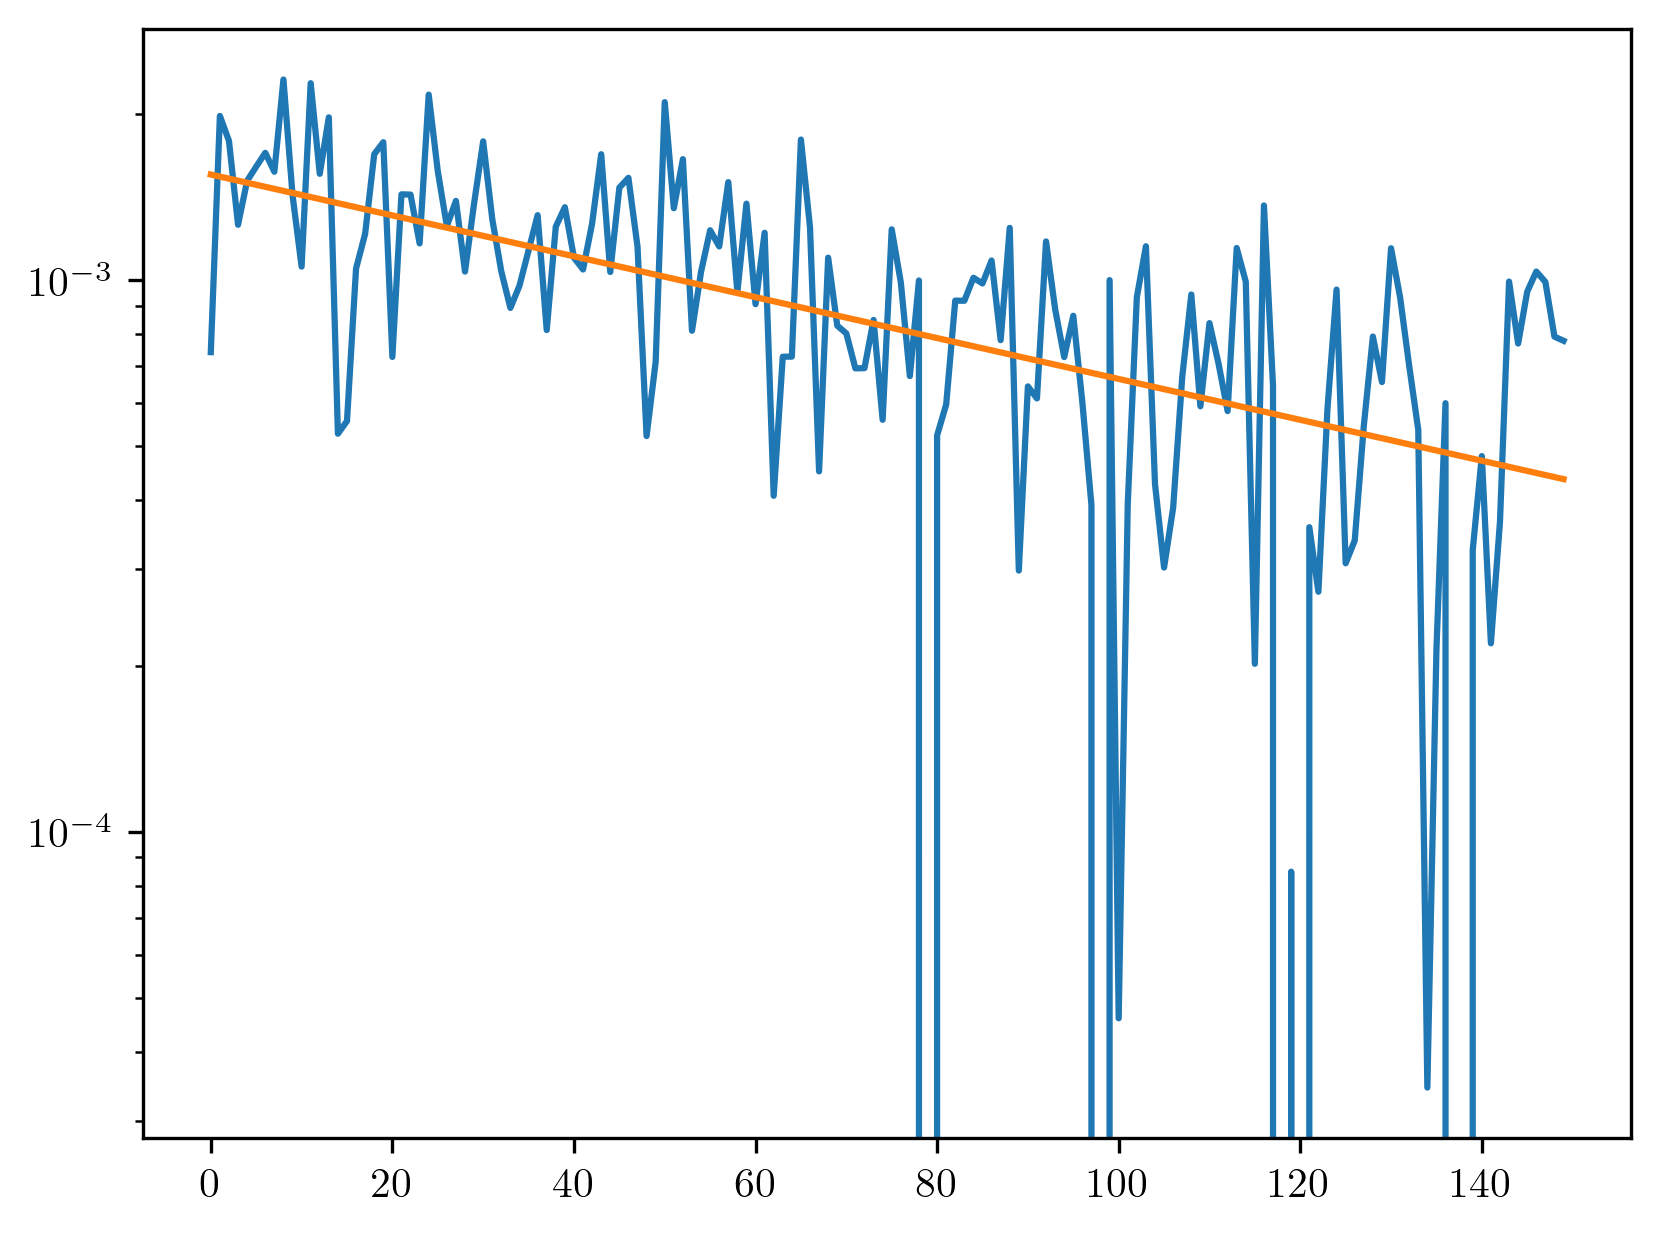

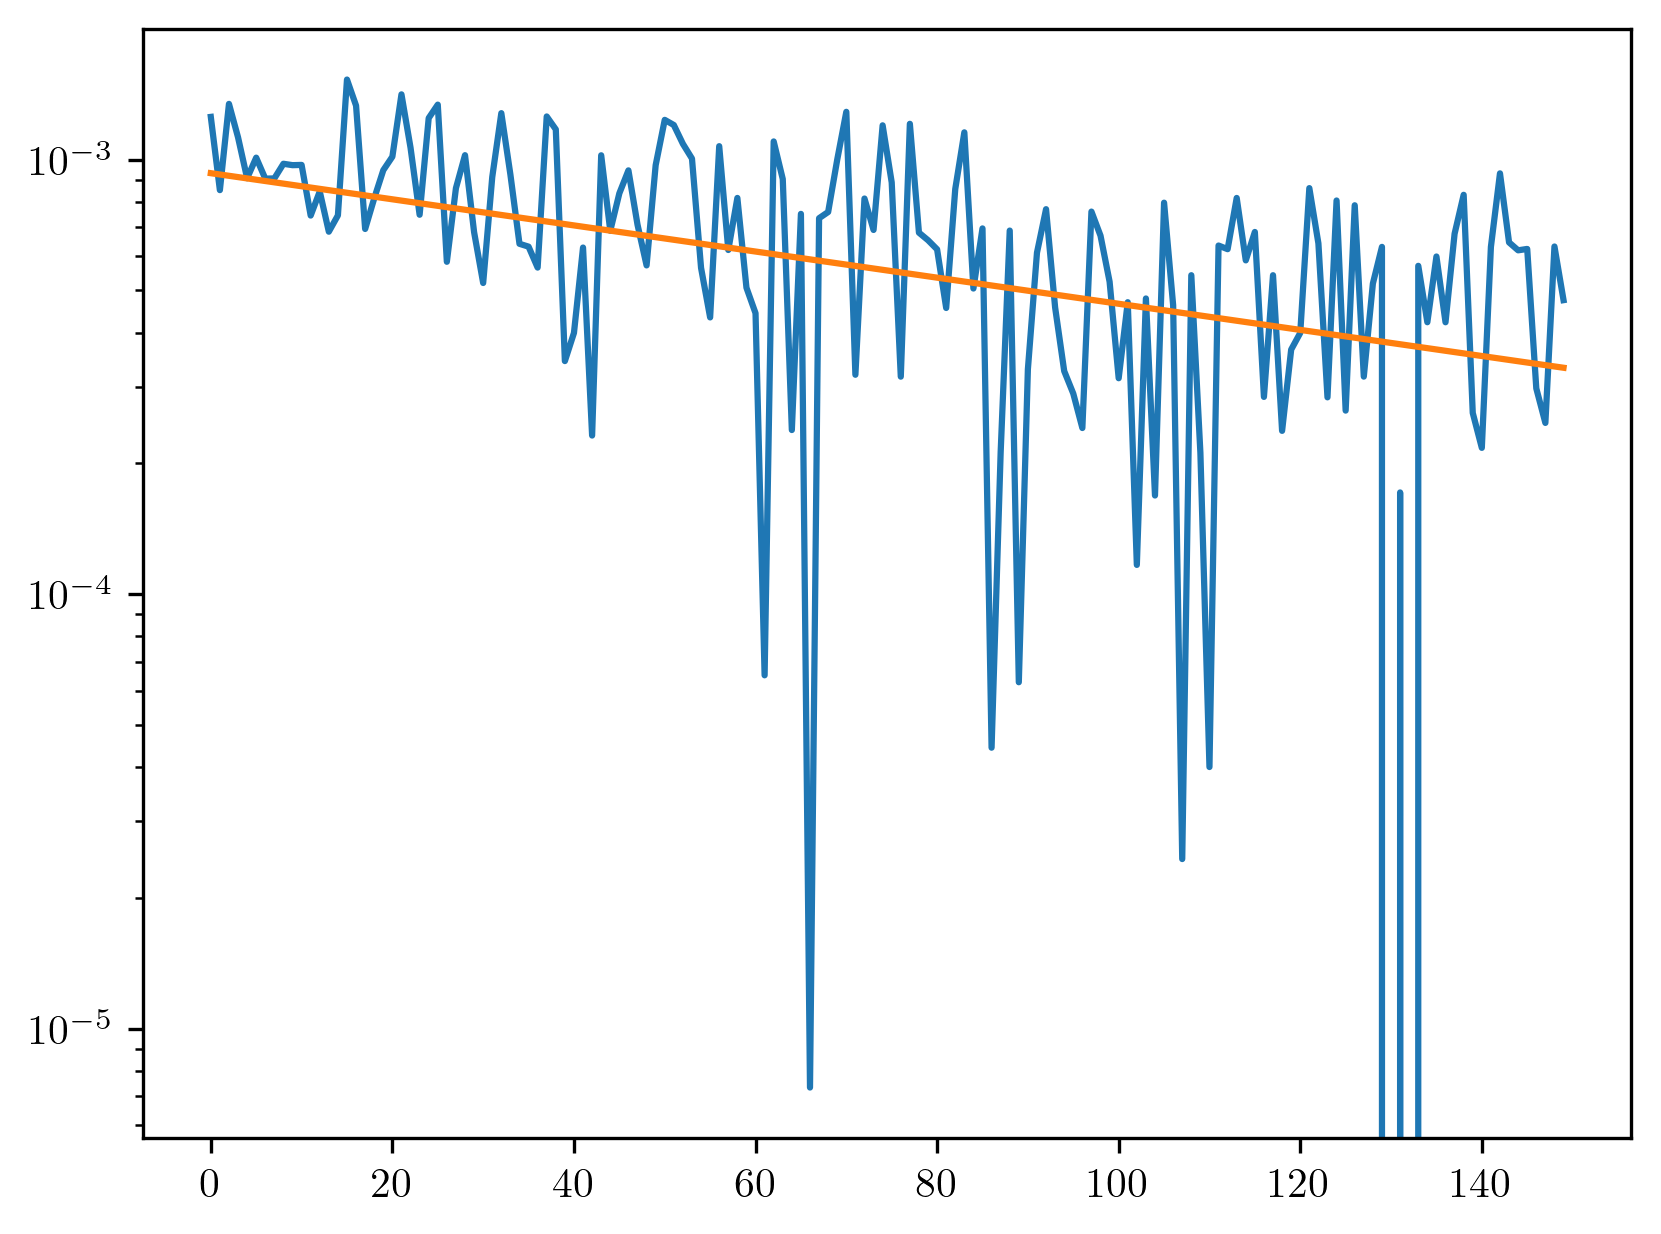

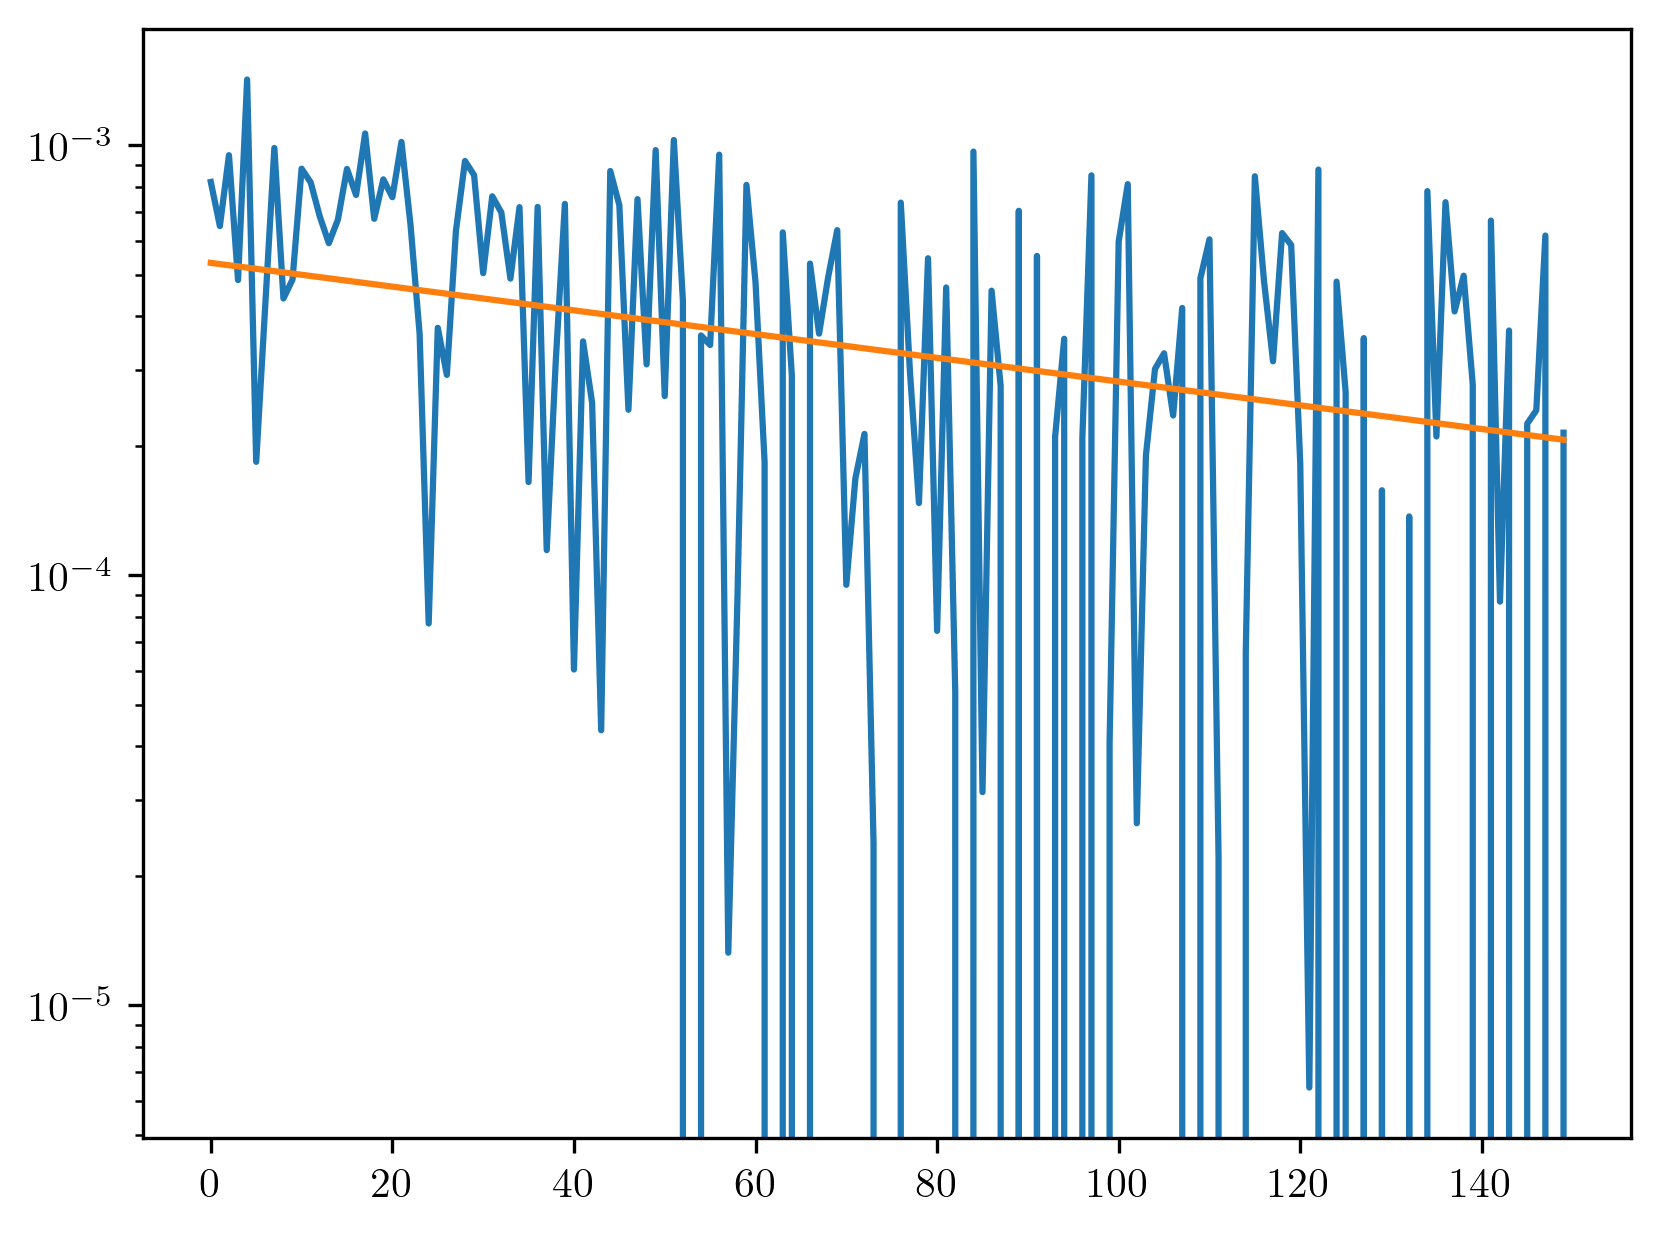

In [2]:
chippath = '../../DataKian/bTa_LT278W2chip5/'
filename = 'KID5_99dBm__TmK20_avgpulse_ampphase.csv'
length = 90
simtime = 100
dtinit=0.001
dxfrac=1/5

lambdasinnm = [402,673,986,1545]

KIDdict = {}
for lambdanm in lambdasinnm:
    KIDdict[lambdanm] = KID_data(chippath,lambdanm,filename,length)
    KIDdict[lambdanm].fit_tail(showplots=True) # just to plot full pulses
for lambdanm in lambdasinnm:
    KIDdict[lambdanm] = KID_data(chippath,lambdanm,filename,length)
    KIDdict[lambdanm].fit_tail(start=250,end=400,showplots=True) # actually calculate tauqp*

Ls=[]
for lambdanm in lambdasinnm:
    print(KIDdict[lambdanm].tauqpstar,KIDdict[lambdanm].tauqpstarstd)
    print(KIDdict[lambdanm].L)
    Ls.append(KIDdict[lambdanm].L)
L=np.mean(Ls) # use the same linear decay rate for all wavelengths

In [4]:
def prep_data(offset):
    ylist = []
    for lambdanm in lambdasinnm:
        xfit = np.arange(offset,offset+simtime-KIDdict[lambdanm].dt/2,KIDdict[lambdanm].dt)
        indmin = np.argmax(KIDdict[lambdanm].phase)+offset
        indmax = indmin + simtime
        ylist.append(KIDdict[lambdanm].phase[indmin:indmax])
    yfit = np.array(ylist).ravel()
    return xfit, yfit

def func_to_parallelize(t,params):
     SIM = KID_sim(params,dtinit,dxfrac,simtime_approx=simtime,D_const=False,approx2D=False,ringingdtinterp=0.005)
     return np.interp(t,SIM.t_axis_interp,SIM.phaseintime)

def fitfunc(t,eta,sigma,tau,Q0):
    print('eta (-):\t',eta)
    print('sigma (um):\t',sigma)
    print('tau (us):\t',tau)
    print('Q0 (um-1):\t',Q0)
    datalist = Parallel(n_jobs=len(lambdasinnm))(delayed(func_to_parallelize)(t,KID_params(eta_pb=eta,sigma_IC=sigma,trickle_time=tau,Q0=Q0,KID=KIDdict[lambdanm],L=L)) for lambdanm in lambdasinnm)
    return np.concatenate(datalist)

def par_func_plot(params):
     SIM = KID_sim(params,dtinit,dxfrac,simtime_approx=simtime,D_const=False,approx2D=False,ringingdtinterp=0.005)
     return SIM

def plotsim(eta,sigma,tau,Q0):
    datalist = Parallel(n_jobs=4)(delayed(par_func_plot)(KID_params(eta_pb=eta,sigma_IC=sigma,trickle_time=tau,Q0=Q0,KID=KIDdict[lambdanm],L=L)) for lambdanm in lambdasinnm)
    plotdata = {}
    for obj,lambdanm in zip(datalist,lambdasinnm):
         plotdata[lambdanm]=obj
    return plotdata

In [5]:
xfit,yfit=prep_data(-5) #e.g. -5 means take 5 data points before the max into account for the data
popt, pcov = curve_fit(fitfunc,xfit,yfit,p0=[0.9,10,0.2,0.5],bounds=[[0.01,0.2,0.01,0.1],[1,length/6,10,np.inf]]) #with tau
print('\nDone!')

# Display parameters, standard deviation, and correlation coefficient
parameters = ['eta','sigma','tau','Q0']
print("Parameters:")
for name, param, std in zip(parameters,popt,np.sqrt(np.diag(pcov))):
    print(f"{name}:\t{param:.10f}\t+/-\t{std:.10f}")

print("\nCorrelation Coefficients:")
for i in range(len(popt)):
    for j in range(i+1, len(popt)):
        print(f"{parameters[i]} vs {parameters[j]}: {pcov[i,j]/np.prod(np.sqrt(pcov[i,i]*pcov[j,j])):.10f}")

"xfit,yfit=prep_data(-5) #e.g. -5 means take 5 data points before the max into account for the data\npopt, pcov = curve_fit(fitfunc,xfit,yfit,p0=[0.9,10,0.2,0.5],bounds=[[0.01,0.2,0.01,0.1],[1,length/6,10,np.inf]]) #with tau\nprint('\nDone!')"

In [7]:
'''
Parameters:
eta:	0.9479031300	+/-	0.0512565369
sigma:	10.8835816586	+/-	2.0517380410
tau:	0.0797164612	+/-	0.0003117077
Q0:	0.9504102818	+/-	0.1396405077

Correlation Coefficients:
eta vs sigma: 0.5822337755
eta vs tau: 0.0899333516
eta vs Q0: -0.3581657089
sigma vs tau: -0.3614819908
sigma vs Q0: -0.9609956775
tau vs Q0: 0.3335807518
'''

simdata = plotsim(0.9479031300,10.8835816586,0.0797164612,0.9504102818)

Iteration: 1236	Simtime (us): 100.06318370344098
max Teff =  0.18089173164620573
Iteration: 1461	Simtime (us): 100.12847060964262
max Teff =  0.16673694633226577
Iteration: 1427	Simtime (us): 100.02174384755705
max Teff =  0.17260372998597287
Iteration: 1769	Simtime (us): 100.17739794412721
max Teff =  0.16015053004151614


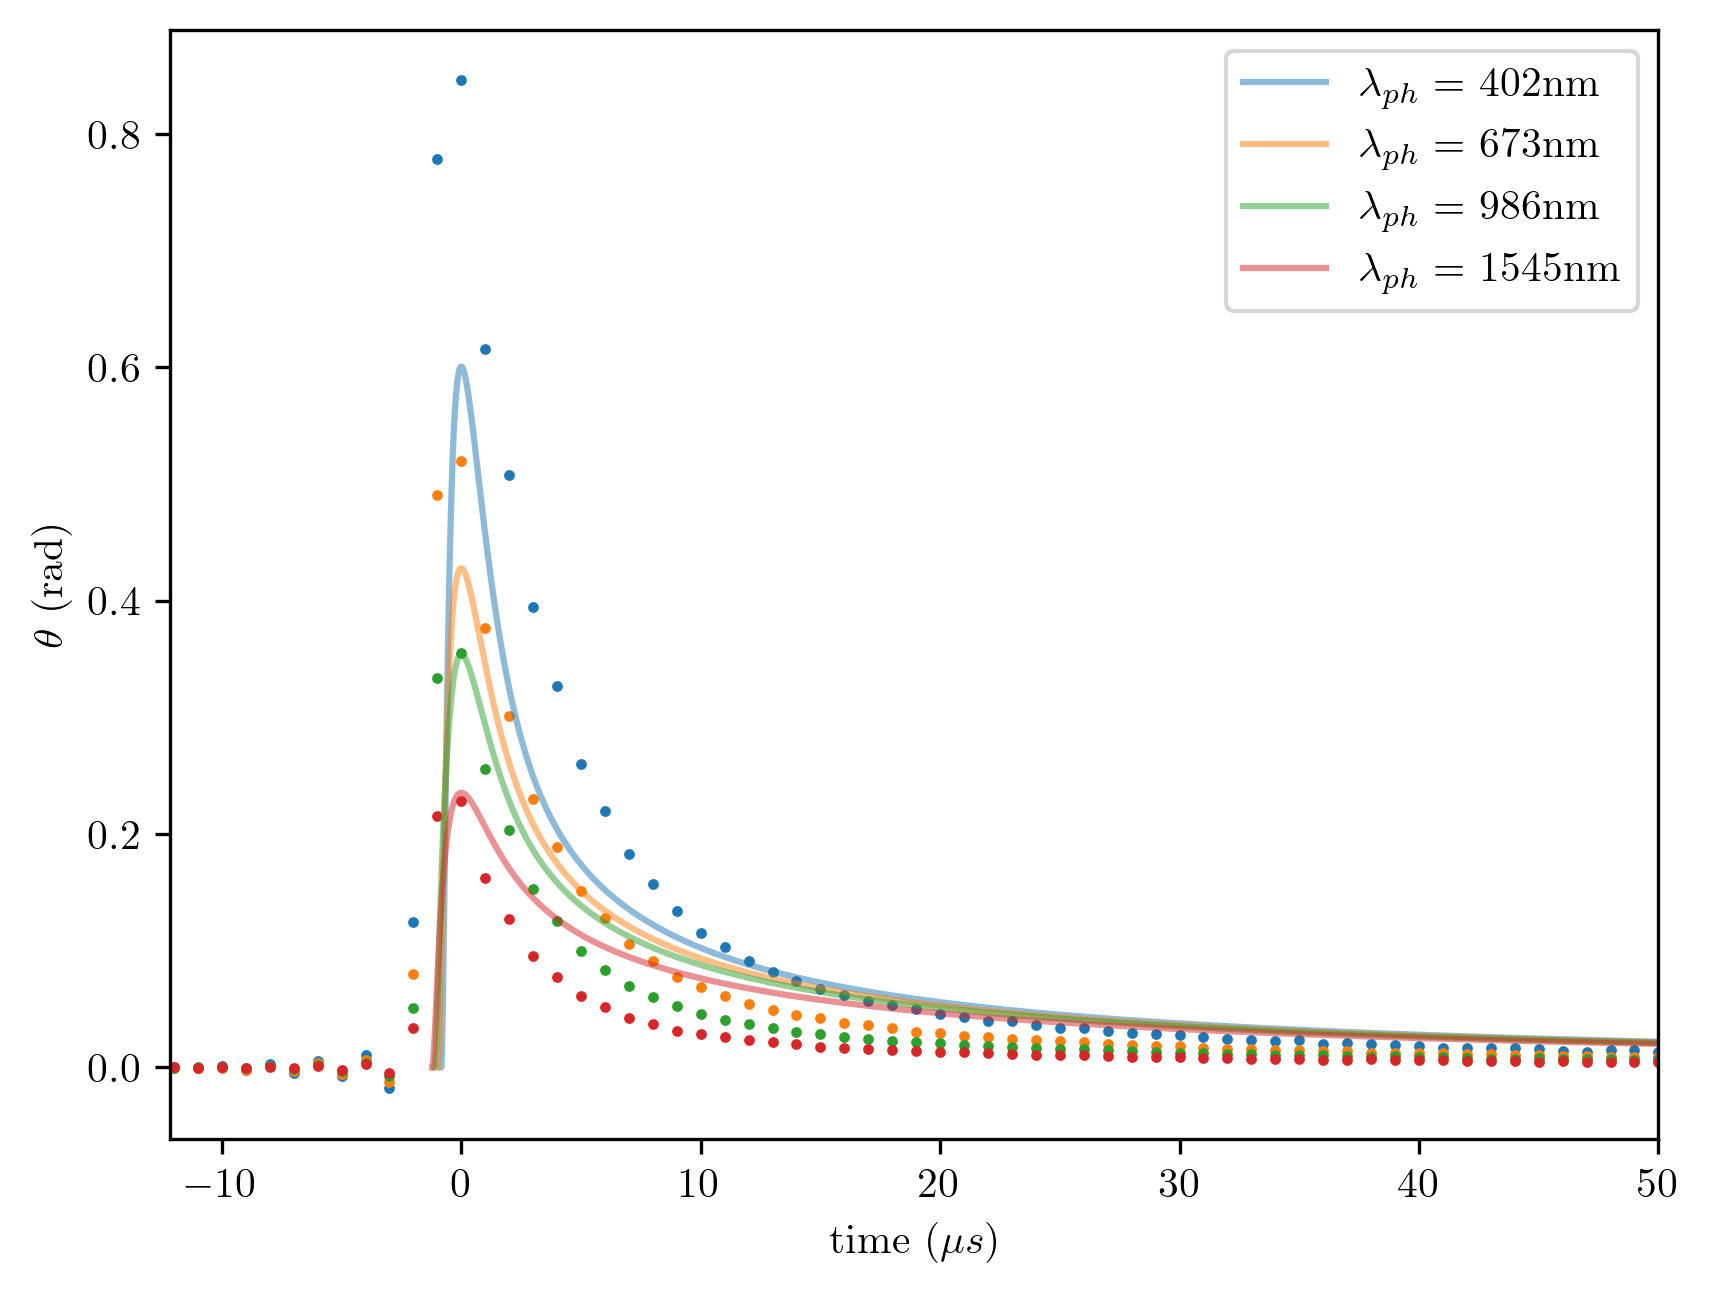

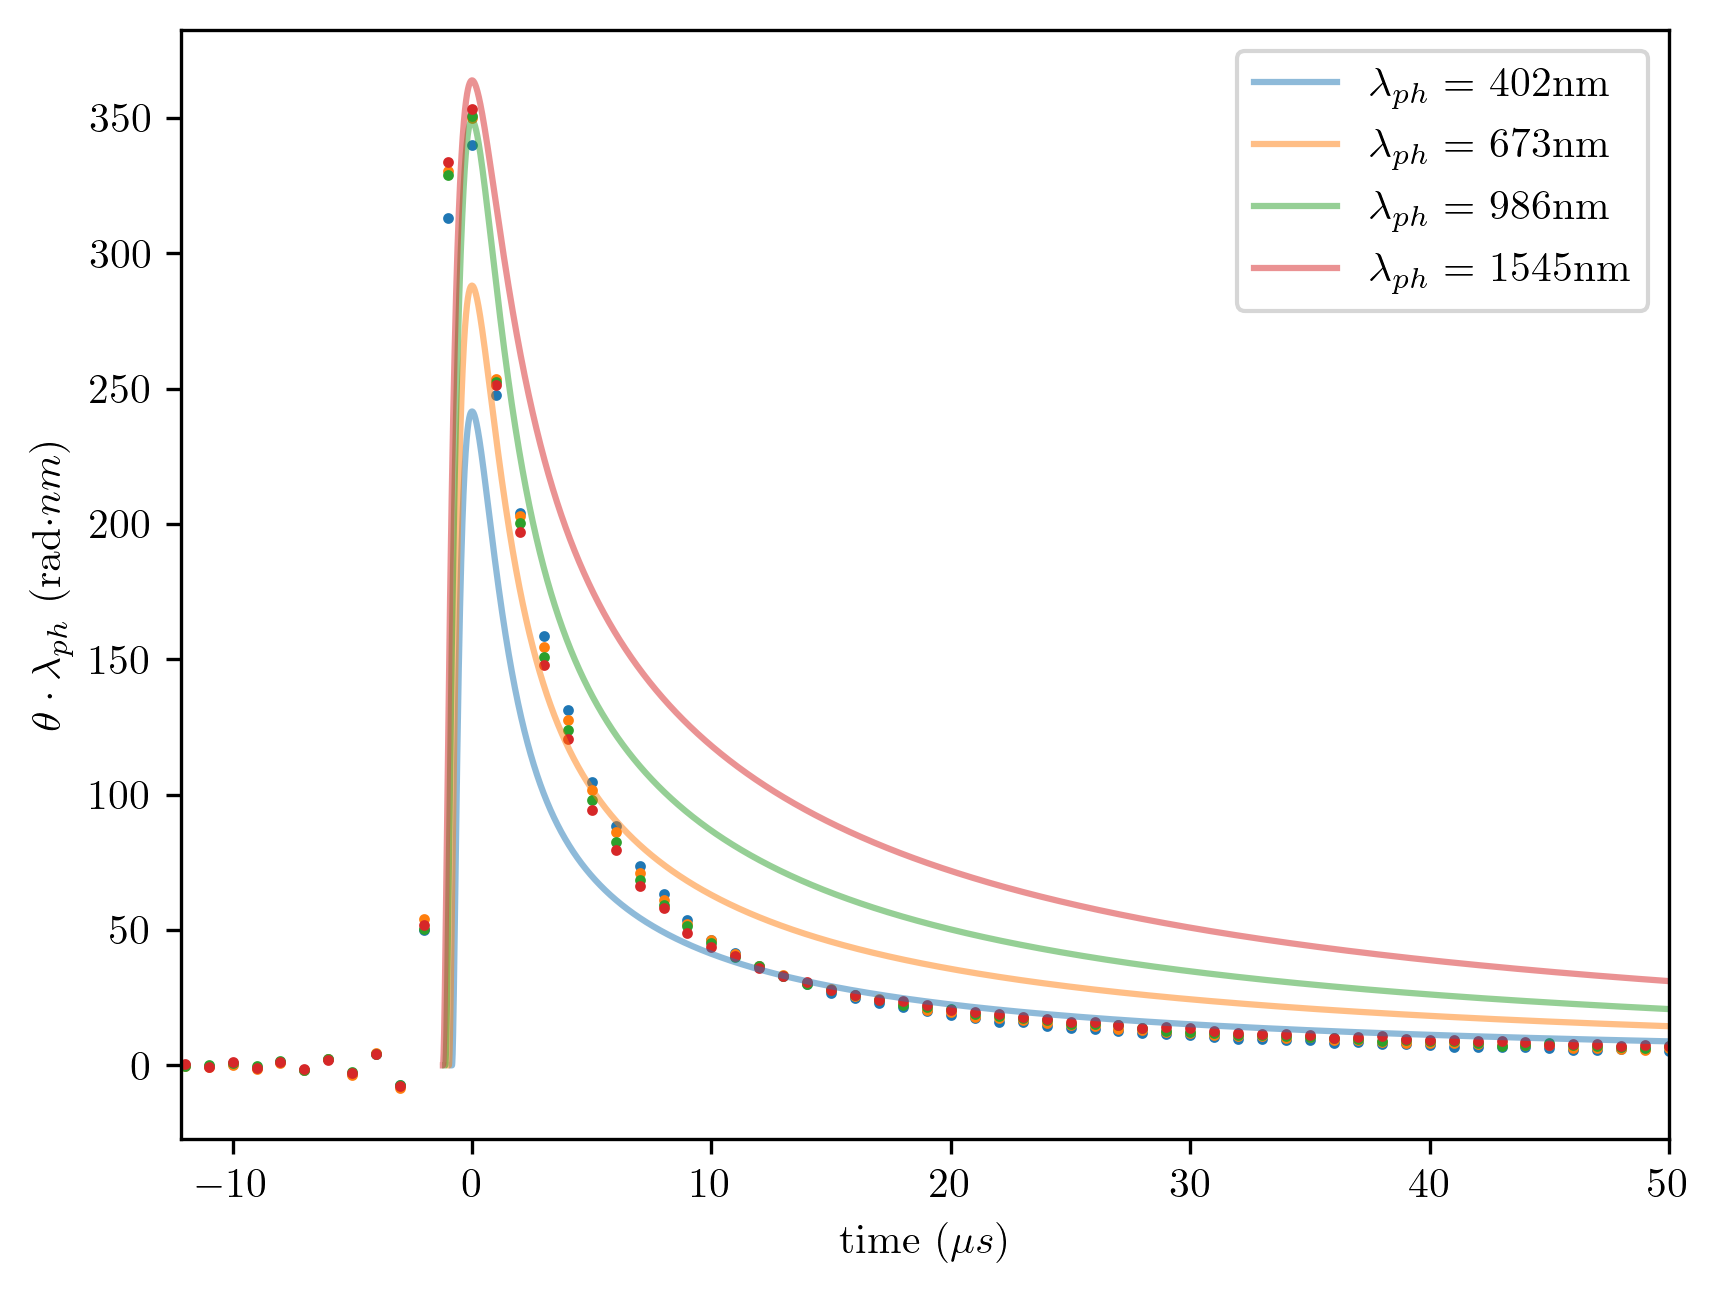

In [8]:
simdata = plotsim(popt[0],popt[1],popt[2],popt[3])

plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    plt.plot(simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime,alpha=0.5,label=r'$\lambda_{ph}=$\ '+str(lambdanm)+r'nm')
    plt.scatter(t,phase,marker='.',s=10)
plt.xlim(10*simdata[lambdanm].t_start,50)
plt.xlabel(r'time ($\mu s$)')
plt.ylabel(r'$\theta$ (rad)')
#plt.ylim(1e-3)
#plt.semilogy()
plt.legend()
plt.show()
plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    plt.plot(simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime*lambdanm,alpha=0.5,label=r'$\lambda_{ph}=$\ '+str(lambdanm)+r'nm')
    plt.scatter(t,phase*lambdanm,marker='.',s=10)
plt.xlim(10*simdata[lambdanm].t_start,50)
plt.xlabel(r'time ($\mu s$)')
plt.ylabel(r'$\theta\cdot\lambda_{ph}$ (rad$\cdot nm$)')
#plt.ylim(1e-3)
#plt.semilogy()
plt.legend()
plt.show()